# Project 2: Moneyball!
Emily O'Connell <br />
Professor Mattei  <br />
CMPS 3160 <br />
November 10, 2020

## Part 1: Wrangling

The first step is to import the libraries to be able to run SQLite and pandas and then open the SQLite file and create onnection object (conn) that represents the database.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

After the data is imported, the next step is to write queries that help manipulate the data. The first query displays the team salary data, showing the Team ID, Year ID, and the total payroll for each team each year.

In [2]:
salaries_query = "SELECT teamID, yearID, sum(salary) as payroll FROM Salaries GROUP BY teamID, yearID"
salaries = pd.read_sql(salaries_query, conn)
salaries.head()
salaries["payroll_in_millions"] = salaries.payroll/1000000
salaries

,teamID,yearID,payroll,payroll_in_millions
0,ATL,1985,14807000.0,14.807000
1,BAL,1985,11560712.0,11.560712
2,BOS,1985,10897560.0,10.897560
3,CAL,1985,14427894.0,14.427894
4,CHA,1985,9846178.0,9.846178
...,...,...,...,...
855,SLN,2014,120693000.0,120.693000
856,TBA,2014,72689100.0,72.689100
857,TEX,2014,112255059.0,112.255059
858,TOR,2014,109920100.0,109.920100


The next query displays the Team ID, Year ID, number of wins, and number of games played for each team each year. The results can then be used to calculate the win percentage.

In [3]:
teams_query = "SELECT teamID, yearID, W as wins, G as games_played FROM Teams GROUP BY teamID, yearID"
teams = pd.read_sql(teams_query, conn)

# add a column win_percent that is the number of wins divided by number of games played
teams["win_percent"] = (teams.wins/teams.games_played) * 100

# drop wins and games_played because we no longer need them
teams.drop(["wins", "games_played"], axis = 1, inplace=True)
teams.head()

,teamID,yearID,win_percent
0,ALT,1884,24.000000
1,ANA,1997,51.851852
2,ANA,1998,52.469136
3,ANA,1999,43.209877
4,ANA,2000,50.617284


Now, we join the two tables. Since there is no one unique primary key, as each team appears in multiple years and each year has data for multiple teams, the primary key is the combination of each team each year, which should be unique. Inner join is the best choice beacuse that will only return the teams each year that have both win and salary data, eleminating issues of missing data.

In [4]:
teams_salaries = pd.merge(teams, salaries, how='inner', on=['teamID', 'yearID'])
teams_salaries.head()

,teamID,yearID,win_percent,payroll,payroll_in_millions
0,ANA,1997,51.851852,31135472.0,31.135472
1,ANA,1998,52.469136,41281000.0,41.281000
2,ANA,1999,43.209877,55388166.0,55.388166
3,ANA,2000,50.617284,51464167.0,51.464167
4,ANA,2001,46.296296,47535167.0,47.535167


Now the dataframe is ready! To check the dataframe, here are the results (comparing win percentage and total payroll) of the Houston Astros from 1985 to 2014.

Text(0, 0.5, 'Percent games won')

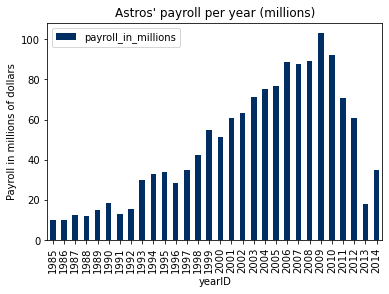

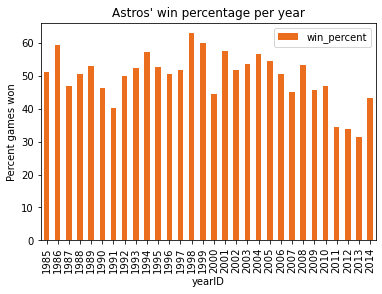

In [5]:
Astros = teams_salaries.loc[(teams_salaries.teamID == "HOU")]
ax = Astros.plot.bar(x='yearID', y='payroll_in_millions', title = "Astros' payroll per year (millions)", color = "#002D62")
ax.set_ylabel("Payroll in millions of dollars")
ax1 = Astros.plot.bar(x='yearID', y='win_percent', title = "Astros' win percentage per year", color = "#EB6E1F")
ax1.set_ylabel("Percent games won")

##### Here's the same data (with payroll scaled by millions) compared side by side

Text(0.5, 1.0, "Comparing Astros' payroll and win percent in different years")

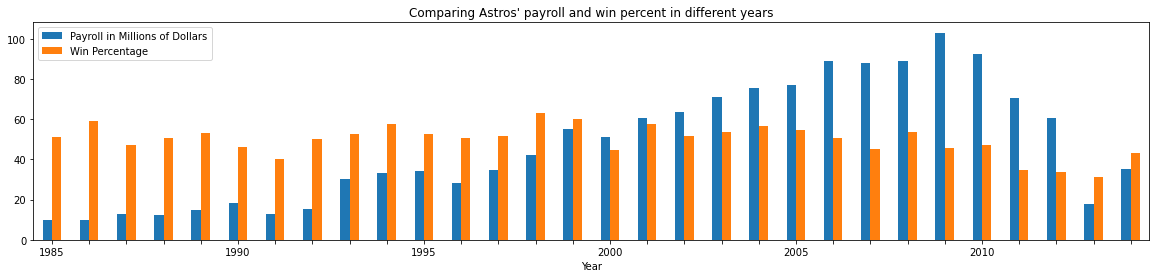

In [6]:
df = pd.DataFrame({'Payroll in Millions of Dollars': Astros.payroll_in_millions,
                'Win Percentage': Astros.win_percent})
df = df.set_index(Astros.yearID)
ax = df.plot.bar(rot=0, figsize=[20,4])
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
ax.set_xlabel("Year")
ax.set_title("Comparing Astros' payroll and win percent in different years")

## Part 2: Exploratory Data Analysis

### Payroll Distribution

#### Heatmap of the distribution of payrolls across teams from 1990-2014

Text(0.5, 1.0, 'Payrolls from 1990-2014 in millions of dollars\n')

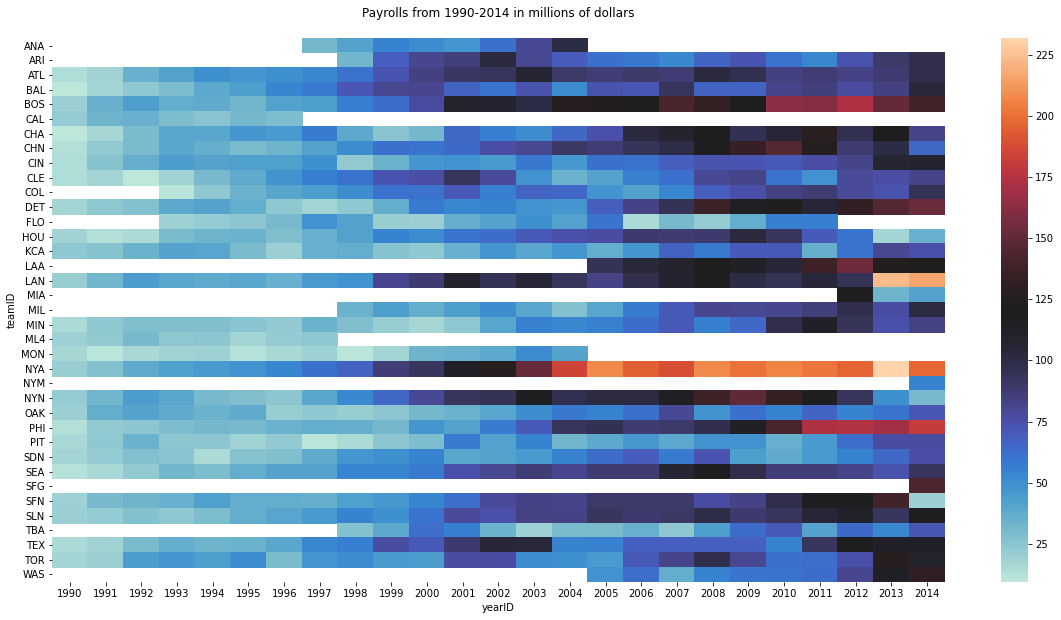

In [7]:
salaries_since_1990 = salaries[salaries.yearID >= 1990]
table = pd.pivot_table(salaries_since_1990, values= "payroll_in_millions", index=['teamID'], columns=['yearID'])
fig, ax = plt.subplots(figsize=(20,10)) 
ax = sns.heatmap(table, cmap="icefire")
ax.set_title("Payrolls from 1990-2014 in millions of dollars\n")

In the 90s, payroll amounts were pretty consistent with no outliers. As time goes on, not only do the payroll amounts get larger, but more extreme values (more extreme highs than extreme lows) are introduced (indicated by the warms colors on the heatmap).

#### Scatterplot of win percentage vs total payroll

Text(0.5, 1.0, 'Scatterplot of win percentage vs total payroll\n')

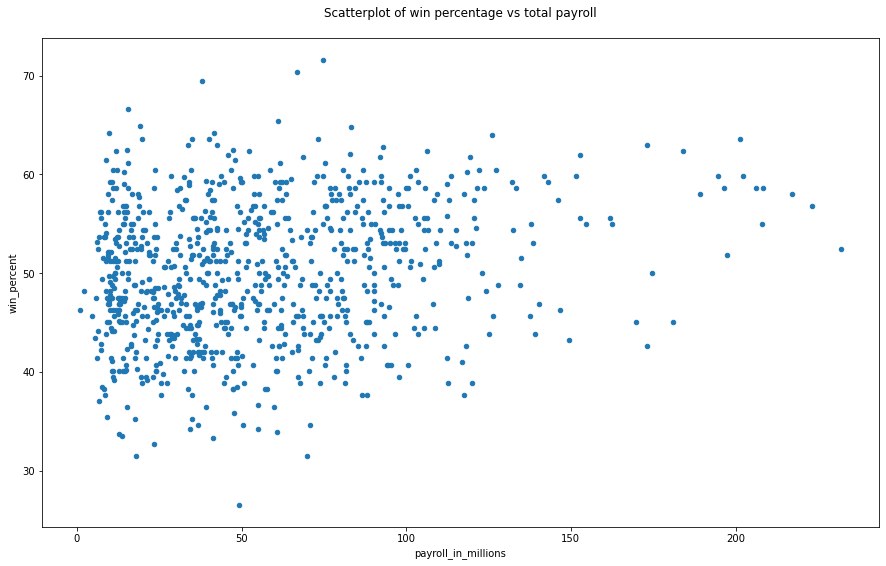

In [8]:
ax1 = teams_salaries.plot.scatter(x='payroll_in_millions',
                      y='win_percent', figsize=(15,9))
ax1.set_title("Scatterplot of win percentage vs total payroll\n")

## Question 1 - payroll distribution trends
What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, and other statistics discussed in class. <br /><br />

On average throughout the league, payrolls trended upward from 1990 to 2014. However, not all teams vastly increased their payroll over the time period, leading to a greater spread in the more recent years than in the 90s. 

#### Question 1 - Additional Plots

Text(0, 0.5, 'average payroll (millions)')

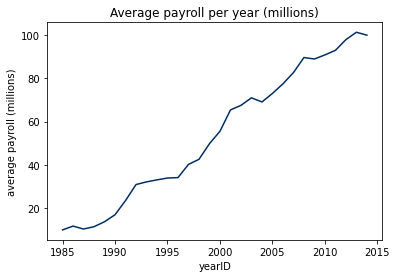

In [9]:
# graph the trend of payroll over time
payroll_by_year = teams_salaries.groupby(teams_salaries.yearID)
average_payroll = payroll_by_year.payroll_in_millions.mean()
ax = average_payroll.plot.line(x='yearID', y='payroll_in_millions', title = "Average payroll per year (millions)", color = "#002D62")
ax.set_ylabel("average payroll (millions)")

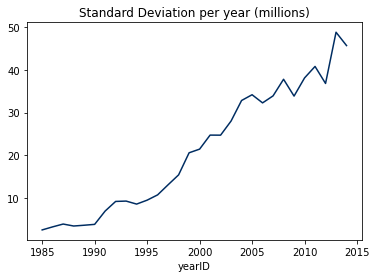

In [10]:
# graph the trend of payroll over time
payroll_std = payroll_by_year.payroll_in_millions.std()
ax = payroll_std.plot.line(x='yearID', y='x', title = "Standard Deviation per year (millions)", color = "#002D62")

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Boxplot showing payroll values by year')

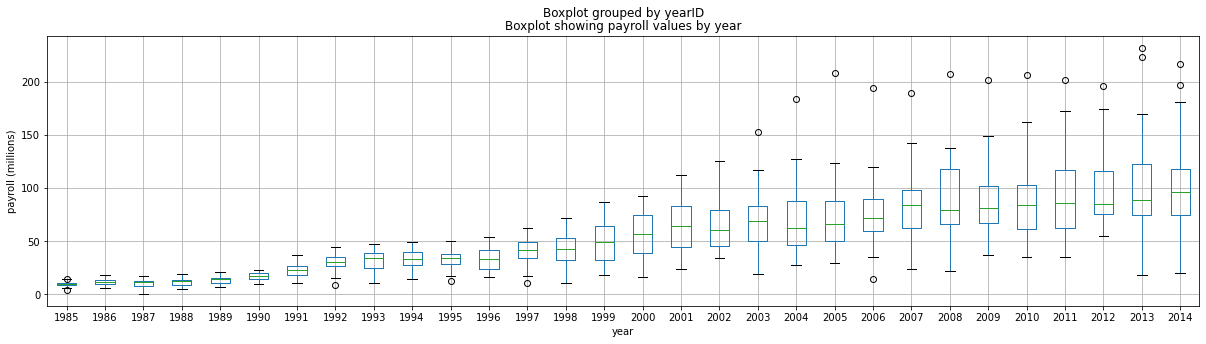

In [11]:
# create boxplots of payroll data by year
ax = teams_salaries.boxplot(column=["payroll_in_millions"], by = "yearID", figsize=[20,5])
ax.set_xlabel("year")
ax.set_ylabel("payroll (millions)")
ax.set_title("Boxplot showing payroll values by year")

The first plot shows a general trend of the league average payroll increasing over time. Although sometimes from year to year the average does go down, overall the data shows a steady increase. While the mean is generally increasing over time, so is the standard deviation. This means that the average distance away from the mean is generally increasing, so the spread is increasing as well.

The boxplots address both center and spread in different ways from the first two graphs. The green line represents the median payroll (which is more resistant to outliers than the mean). The blue box represents the interquartile range (IQR), a measure of spread. The top bar represents the maximum and the bottom bar is the minimum. Any dots that appear outside the max or min indicate outliers. 

Like the mean, the median shows a general increase overtime, although it is much less drastic than the mean. The relitively larger increase in the mean is partially because of outliers bringing the mean up, as there are many outliers above the maximum beginning in 2003. Similarly, the general increase in the IQR over time confirms that the spread increases over time, as seen in examining the standard deviation overtime. 

As the median and mean and the standard deviation and IQR increase over time, it is safe to say that the typical payroll is increasing both in value and spread.

### Correlation Between Payroll and Winning Percentage

In [12]:
# only use dates 1990 and after
salaries_since_1990 = salaries[salaries.yearID >= 1990]
teams_salaries = teams_salaries[teams_salaries.yearID >= 1990]

In [13]:
# create 5 groups (numbered for simplicity) that corespond to 5 time periods
teams_salaries["group"] = pd.cut(teams_salaries.yearID, 5, precision=0, labels=[1, 2 ,3 ,4 ,5])
group1 = teams_salaries[teams_salaries["group"]==1]
group2 = teams_salaries[teams_salaries["group"]==2]
group3 = teams_salaries[teams_salaries["group"]==3]
group4 = teams_salaries[teams_salaries["group"]==4]
group5 = teams_salaries[teams_salaries["group"]==5]

<ipython-input-13-9d82045e19e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_salaries["group"] = pd.cut(teams_salaries.yearID, 5, precision=0, labels=[1, 2 ,3 ,4 ,5])


In [14]:
# Show the values of the categories to match them to the scatter plot
pd.cut(teams_salaries.yearID, 5, precision=0).unique()

[(1995.0, 2000.0], (2000.0, 2004.0], (2004.0, 2009.0], (2009.0, 2014.0], (1990.0, 1995.0]]
Categories (5, interval[float64]): [(1990.0, 1995.0] < (1995.0, 2000.0] < (2000.0, 2004.0] < (2004.0, 2009.0] < (2009.0, 2014.0]]

##### (1990-1995] Standardized Scatterplot with regression line

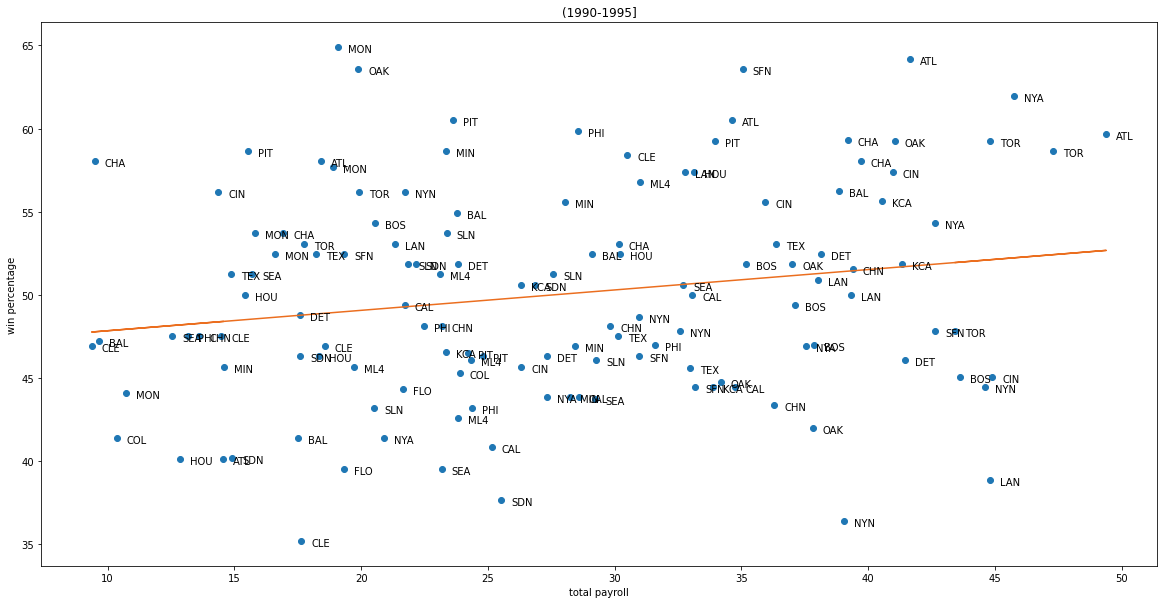

In [43]:
x = group1.payroll_in_millions
y = group1.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(1990-1995]")

x_list = x.tolist()
y_list = y.tolist()

label = group1.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points')
    
plt.xlabel("total payroll")
plt.ylabel("win percentage")

plt.show()

# put summary stats into a df column
summary_frame = pd.DataFrame(index=["slope", "intercept", "r_value", "p_value", "std_err"])
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame['(1990-1995]'] = summary_stats

##### (1995-2000] Scatterplot with regression line

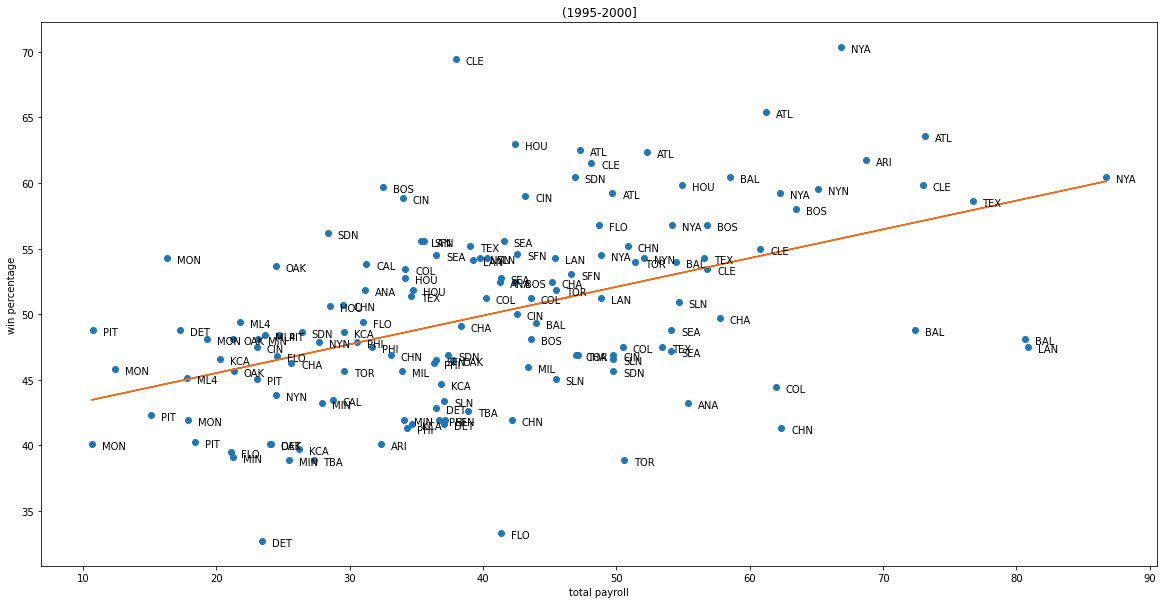

In [42]:
x = group2.payroll_in_millions
y = group2.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(1995-2000]")

x_list = x.tolist()
y_list = y.tolist()

label = group2.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points')
    
plt.xlabel("total payroll")
plt.ylabel("win percentage")

plt.show()

# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame['(1995-2000]'] = summary_stats


##### (2000-2005] Scatterplot with regression line

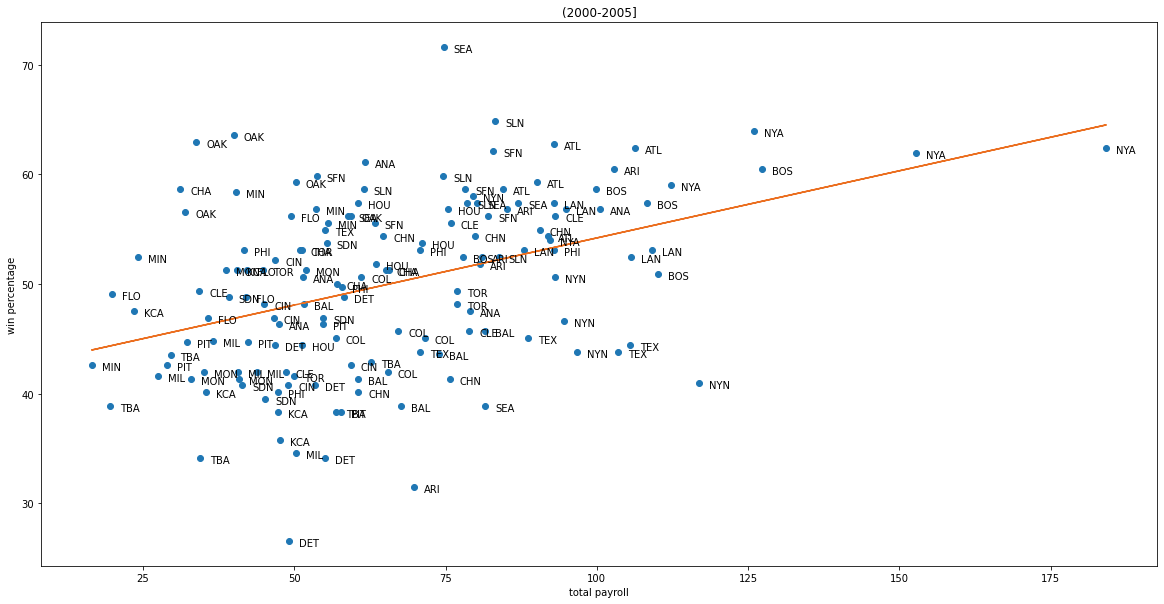

In [41]:
x = group3.payroll_in_millions
y = group3.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2000-2005]")

x_list = x.tolist()
y_list = y.tolist()

label = group3.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points')

plt.xlabel("total payroll")
plt.ylabel("win percentage")


# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame['(2000-2005]'] = summary_stats

##### (2005-2009] Scatterplot with regression line

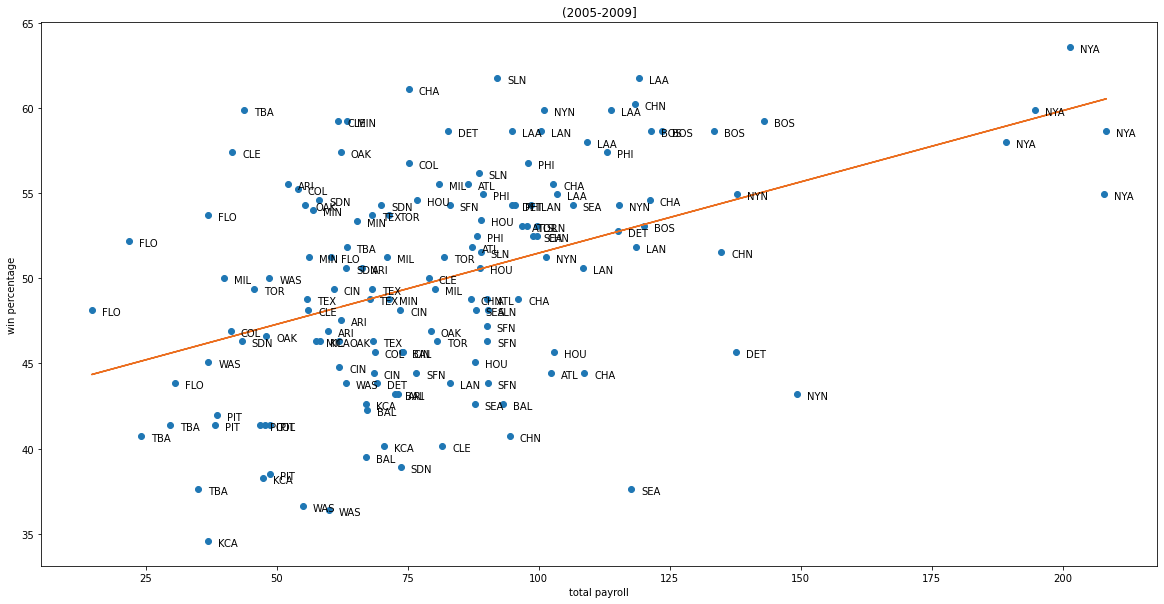

In [45]:
x = group4.payroll_in_millions
y = group4.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2005-2009]")

x_list = x.tolist()
y_list = y.tolist()

label = group4.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points')
    
plt.xlabel("total payroll")
plt.ylabel("win percentage")

plt.show()

# put summary stats into a df column
stats.linregress(x,y)
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame['(2005-2009]'] = summary_stats

##### (2009-2014] Scatterplot with regression line

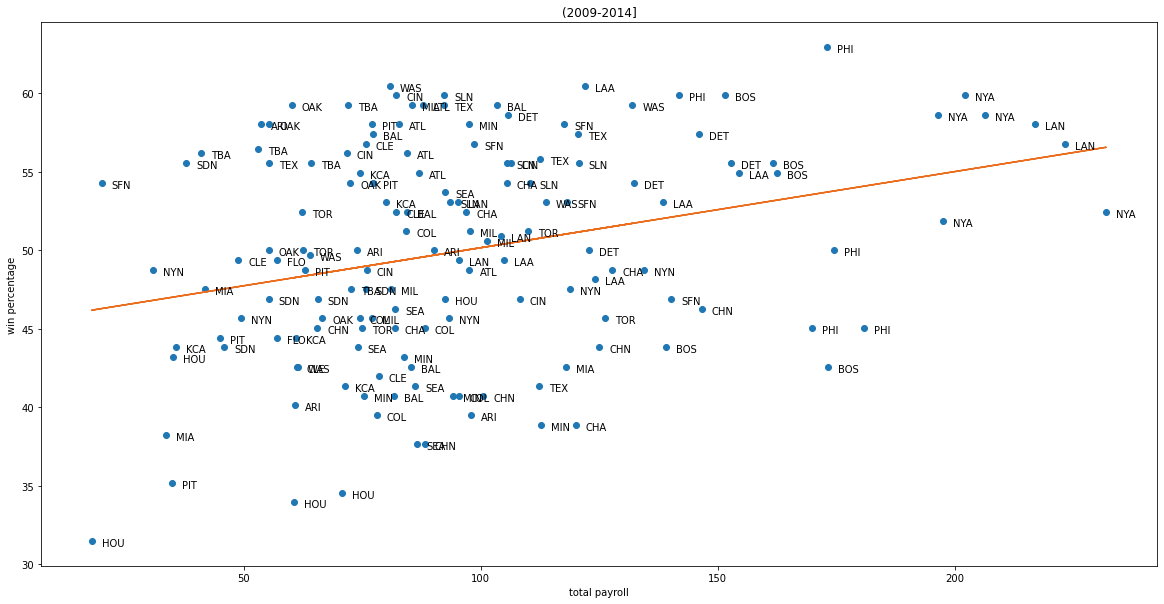

In [46]:
x = group5.payroll_in_millions
y = group5.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2009-2014]")

x_list = x.tolist()
y_list = y.tolist()

label = group5.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points')
plt.xlabel("total payroll")
plt.ylabel("win percentage")

plt.show()

# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame['(2009-2014]'] = summary_stats

## Question 2 - Who pays for wins? Is *Moneyball* worth a movie?
What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods and specifically in the Moneyball period of 2000-2005.

###### Below is a table summarizing the linear regressuion statistics for each time period

In [20]:
summary_frame

,(1990-1995],(1995-2000],(2000-2005],(2005-2009],(2009-2014]
slope,0.1227319,0.2189322,0.1224309,0.0835939,0.0484756
intercept,46.6111600,41.1429515,41.9432024,43.1190593,45.3241685
r_value,0.1894515,0.4830322,0.4135643,0.4499118,0.2960735
p_value,0.0283500,0.0000000,0.0000001,0.0000000,0.0002345
std_err,0.0553650,0.0333040,0.0221557,0.0136397,0.0128550


All time periods show a positive relationship between payroll and win percentage. For each time period except 1990-1995, there is a weak correlation between payroll and win percentage. The relationship is not very linear.
In terms of payroll, in the later peiods, there are more high data values than in earlier periods. The p-value is less than 0.05, which would motivate the rejection of the null hypothesis (H<sub>0</sub> being that the increased winning percentage is due to chance).


Beginning in the early 2000s, the Yankees have a consistently high payroll and were also pretty successful.
In the most recent time frame, the Dodgers also seem to be paying for wins. 
Paying for wins is most effective in 2009-2014 time period compared to earlier periods,
In 2000-2005, the Mariners had the highest win percentage of the period by a good margin, but did not have an especially large payroll.

The A's Moneyball strategy seems to work decetly well. They had a fairly high win percentage spending significantly less money than other teams of a similar caliber. In general, they matched or outperformed the A's from the 1995-2000 time period. This success goes against the overall trend of spending more money to have a better win percentage. Overall, I'd say Moneyball is worth the movie because the A's were successful on a much smaller budget than many other teams in the league. While there is still a lot of chance involved in predicting sports outcomes, making data-based decisions can help improve a team's performance, like in the case of the ["Cowboy Computer"](https://www.espn.com/video/clip/_/id/27324225) used by the Dallas Cowboys in 1962 that helped lead Dallas to be very successful in the 70s.

## Part 3: Data Transformations

#### Standardizing Across Years
It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.
In order to make more helpful comparisons and eleminate some of the confusion caused by the general increase in payroll over time, a z-score will standardize the payroll data

$$ standardized Payroll_{ij} = \frac{payRoll_{ij} - avg PayRoll_{j}}{s_j} $$

In [21]:
# add a column for average payroll and payroll standard deviation using dfs from line graphs in question 1
avg_payroll = average_payroll.to_frame()
zscore_df = pd.merge(avg_payroll, teams_salaries, how='inner', on=['yearID'])
zscore_df =zscore_df.rename(columns={"payroll_in_millions_x": "avg_payroll", "payroll_in_millions_y":"payroll_in_millions"})

In [22]:
# add a column for average payroll and payroll standard deviation using dfs from line graphs in question 1
zscore_df = pd.merge(payroll_std, zscore_df, how='inner', on=['yearID'])
zscore_df =zscore_df.rename(columns={"payroll_in_millions_x": "payroll_std", "payroll_in_millions_y":"payroll_in_millions"})

In [23]:
# calculate the score 
z_score = (zscore_df.payroll_in_millions - zscore_df.avg_payroll) / zscore_df.payroll_std
zscore_df["z_score"] = z_score
zscore_df.head()

,yearID,payroll_std,avg_payroll,teamID,win_percent,payroll,payroll_in_millions,group,z_score
0,1990,3.771834,17.072354,ATL,40.123457,14555501.0,14.555501,1,-0.667275
1,1990,3.771834,17.072354,BAL,47.204969,9680084.0,9.680084,1,-1.959861
2,1990,3.771834,17.072354,BOS,54.320988,20558333.0,20.558333,1,0.924213
3,1990,3.771834,17.072354,CAL,49.382716,21720000.0,21.720000,1,1.232198
4,1990,3.771834,17.072354,CHA,58.024691,9491500.0,9.491500,1,-2.009859


### Correlation Between Payroll and Winning Percentage with standardized payroll

In [24]:
# create 5 groups (numbered for simplicity) that corespond to 5 time periods
zscore_df["group"] = pd.cut(zscore_df.yearID, 5, precision=0, labels=[1, 2 ,3 ,4 ,5])
group1 = zscore_df[zscore_df["group"]==1]
group2 = zscore_df[zscore_df["group"]==2]
group3 = zscore_df[zscore_df["group"]==3]
group4 = zscore_df[zscore_df["group"]==4]
group5 = zscore_df[zscore_df["group"]==5]

##### (1990-1995] Standardized Scatterplot with regression line

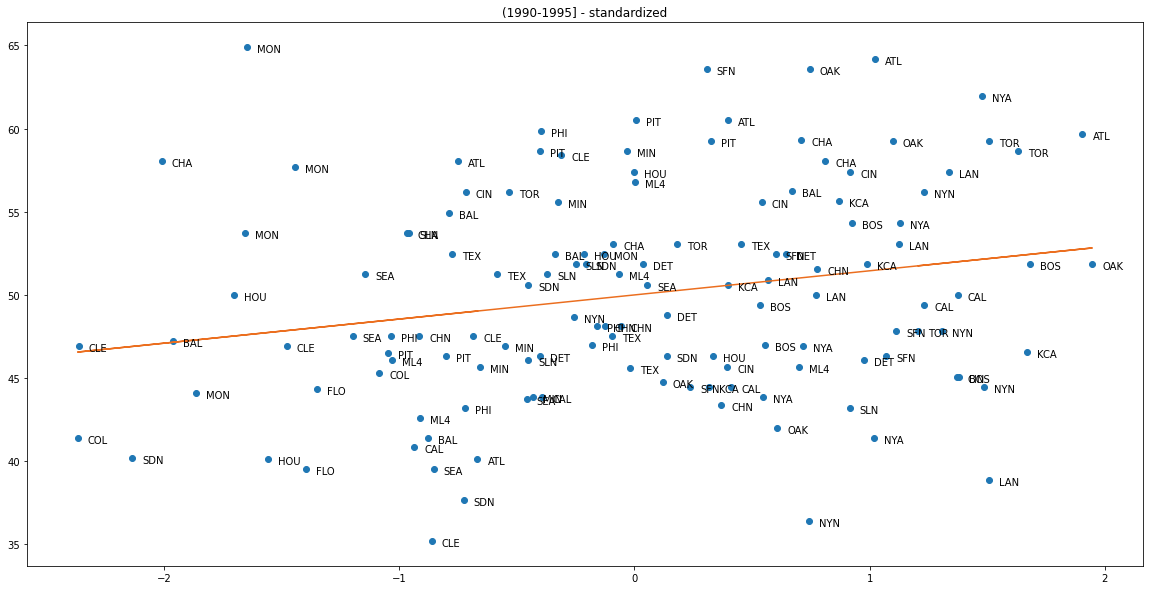

In [25]:
x = group1.z_score
y = group1.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(1990-1995] - standardized")

x_list = x.tolist()
y_list = y.tolist()

label = group1.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points'
                )

plt.show()

# put summary stats into a df column
summary_frame_std = pd.DataFrame(index=["slope", "intercept", "r_value", "p_value", "std_err"])
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_std['(1990-1995]'] = summary_stats

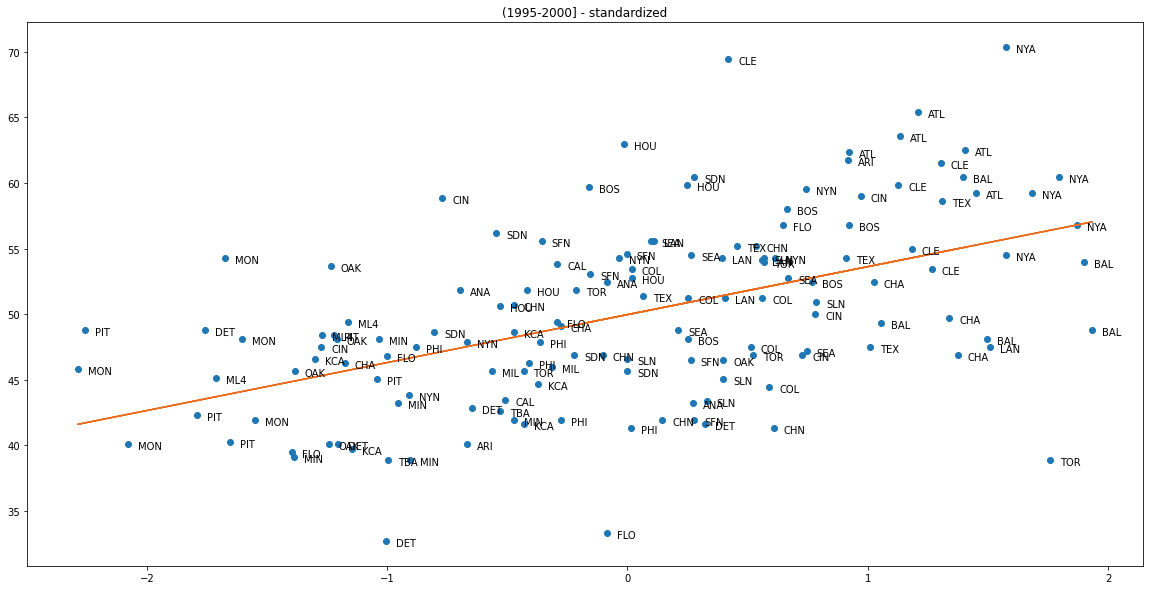

In [26]:
x = group2.z_score
y = group2.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(1995-2000] - standardized")

x_list = x.tolist()
y_list = y.tolist()

label = group2.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points'
                )

plt.show()

# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_std['(1995-2000]'] = summary_stats

##### (2000-2005] Standardized Scatterplot with regression line

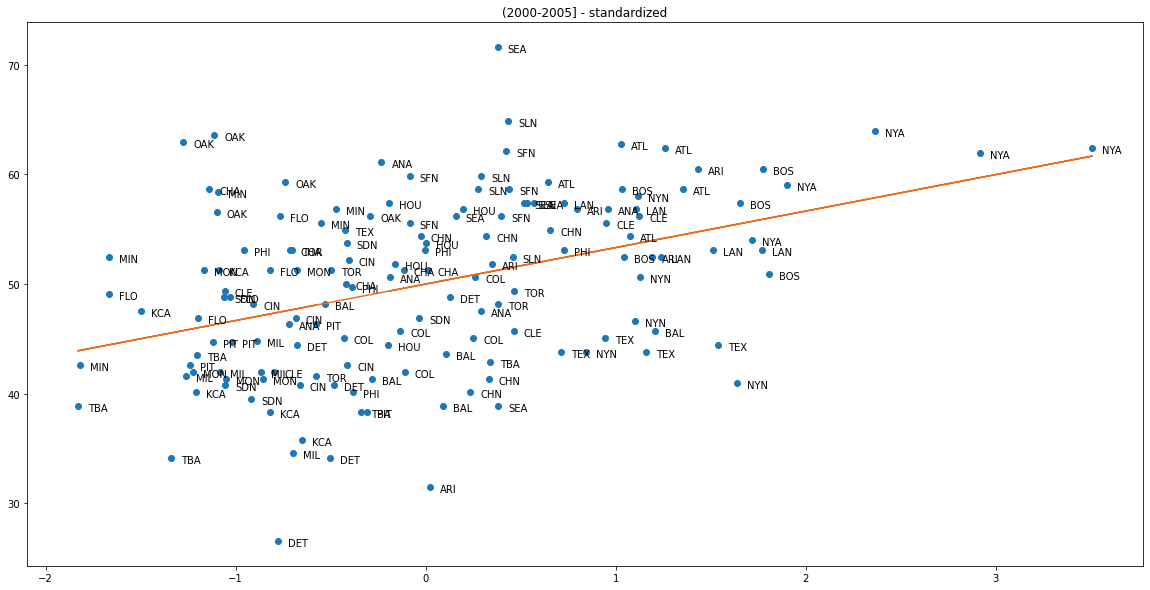

In [27]:
x = group3.z_score
y = group3.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2000-2005] - standardized")

x_list = x.tolist()
y_list = y.tolist()

label = group3.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points'
                )

plt.show()

# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_std['(2000-2005]'] = summary_stats

##### (2005-2009] Standardized Scatterplot with regression line

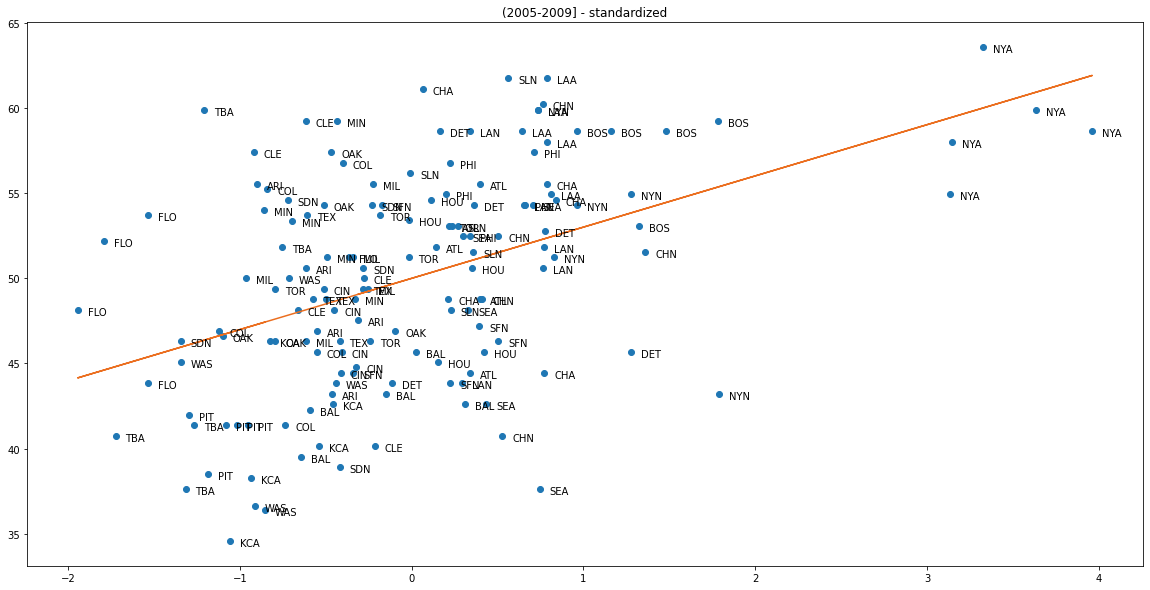

In [28]:
x = group4.z_score
y = group4.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2005-2009] - standardized")

x_list = x.tolist()
y_list = y.tolist()

label = group4.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points'
                )

plt.show()

# put summary stats into a df column
stats.linregress(x,y)
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_std['(2005-2009]'] = summary_stats

##### (2009-2014] Standardized Scatterplot with regression line

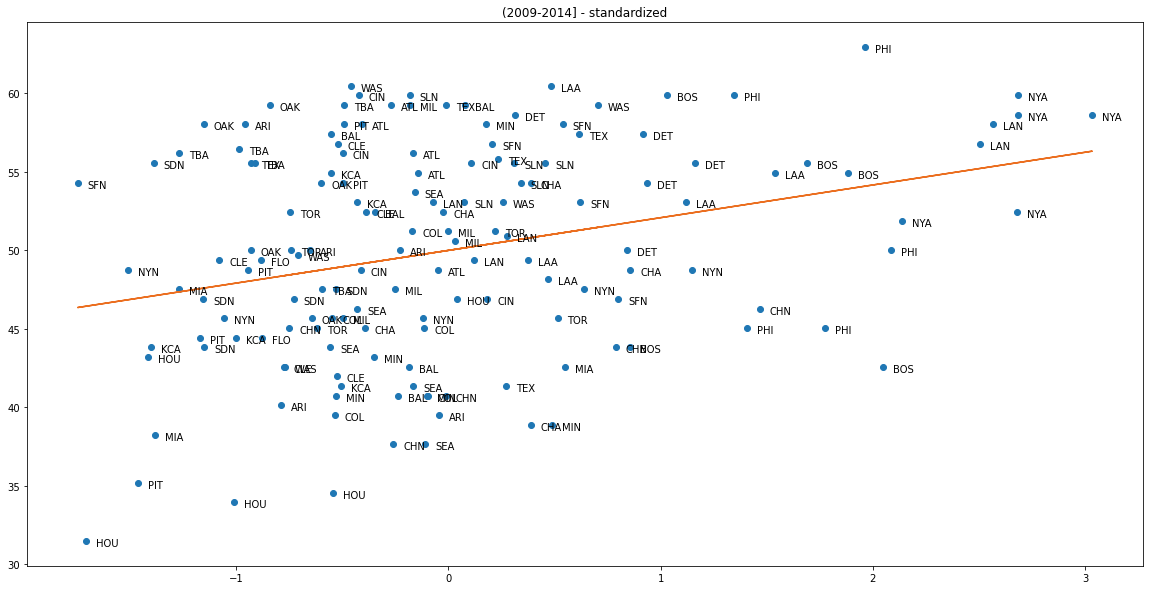

In [29]:
x = group5.z_score
y = group5.win_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("(2009-2014] - standardized")

x_list = x.tolist()
y_list = y.tolist()

label = group5.teamID
for i, txt in enumerate(label):
    plt.annotate(txt, (x_list[i], y_list[i]), 
                xytext=(10,-5), 
                textcoords='offset points'
                )

plt.show()

# put summary stats into a df column
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_std['(2009-2014]'] = summary_stats

## Question 3 - Standardized vs non-standardized data
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable. Specifically, what is easier to see, what is harder to see? Are any relationships more apparent? <br />

###### Below is a table summarizing the linear regressuion statistics for each time period with standardized payroll values


In [30]:
summary_frame_std

,(1990-1995],(1995-2000],(2000-2005],(2005-2009],(2009-2014]
slope,1.4518279,3.6540405,3.3260112,3.0075906,2.0839874
intercept,49.9927440,49.9735963,49.9826713,49.9940822,49.9995206
r_value,0.2236375,0.5135123,0.4135152,0.4616670,0.2994908
p_value,0.0093899,0.0000000,0.0000001,0.0000000,0.0001968
std_err,0.5507345,0.5123977,0.6019771,0.4750166,0.5457255


The slopes are positive, and they are much steaper. The correlations are still weak, but they are stonger than in the non-standardized data. The p-values are smaller, indicating we are right to reject the null hypothesis that the increased winning percentage is due to chance. <br /> <br />
In recent years, a larger payroll tends to indicate a greater chance of success, but a smaller payroll does not necessarily guarantee a low win percentage. It looks like a larger payroll is more valuable in recent years than it was in the 90s <br /> <br />
Standardizing the variables using a z-score shows the variables in relation to the mean and standard deviation for the year, which is more clear given that trends in the data (like measures of center and spread) vary vastly between different years. For example, a team with one of the lowest payrolls in the league in 2014 would have a fairly typical payroll in 1990. By standardizing the data, more revealing and meaningful conclusions can be drawn because it shows the data point's relation to the average of the time rather than out of context. Thus, data standardized with z-scores  more easily show a data point's relation to the mean (negative z-scores being less than average, a z-score of 0 being the mean, and a positive z-score being above average). Arguably, a data point's relation to the mean payroll is more useful than the exact payroll value in this situation because the payrolls vary so much over time. It is more clear to see how teams with less than average, about average, or above average payrolls compare both within one time frame and across time frames. <br /> <br />
Z-scores, by design, make it harder to see the increase in average payroll over the years. If you are researching the trends in payrolls, a z-score wouldn't be the most helpful, and another visualization of non-standardized data like a boxplot displayed previously would be more helpful.

## Expected Wins

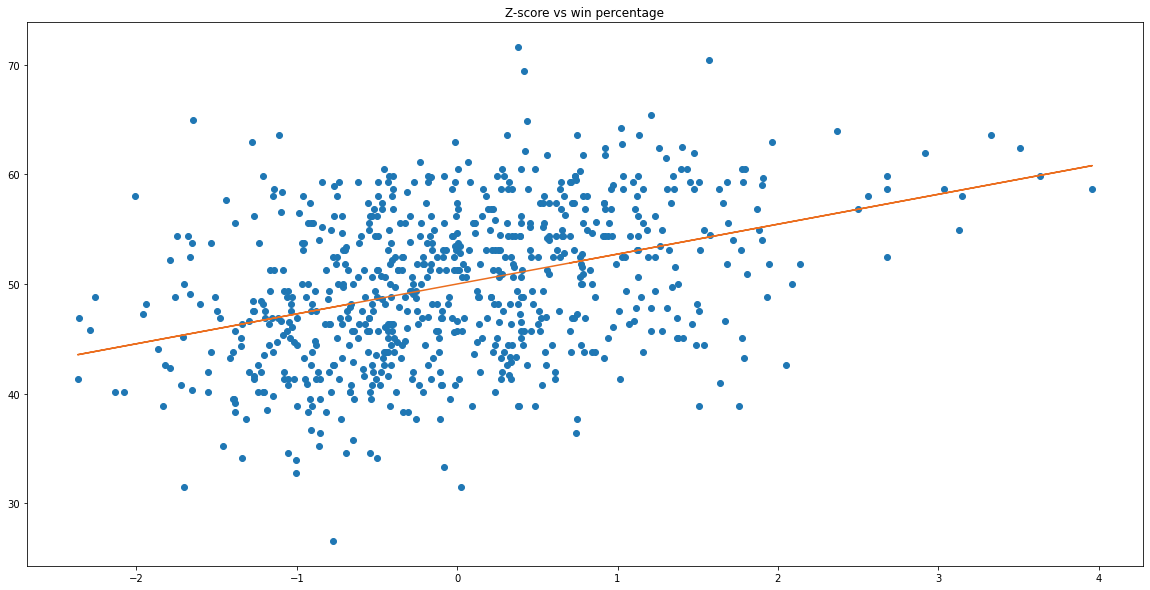

In [31]:
# create scatterplot of z-score vs win percentage
x = zscore_df["z_score"]
y = zscore_df["win_percent"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x, slope*x + intercept, '#EB6E1F')
plt.title("Z-score vs win percentage")

# put summary stats into a df column
summary_frame_all_time = pd.DataFrame(index=["slope", "intercept", "r_value", "p_value", "std_err"])
summary_stats = ["{:.7f}".format(slope),"{:.7f}".format(intercept),"{:.7f}".format(r_value),"{:.7f}".format(p_value), "{:.7f}".format(std_err)]
summary_frame_all_time["1990-2014"] = summary_stats

In [32]:
summary_frame_all_time

,1990-2014
slope,2.7251036
intercept,49.9885531
r_value,0.3860460
p_value,0.0000000
std_err,0.2416754


$$ expectedWinPct_{ij} = 50 + 2.5 \times standardizedPayroll_{ij} $$

In [33]:
# calculate expected win percent
zscore_df["expected_win_pct"] = 50 + (2.5*zscore_df["z_score"])
zscore_df.head()

,yearID,payroll_std,avg_payroll,teamID,win_percent,payroll,payroll_in_millions,group,z_score,expected_win_pct
0,1990,3.771834,17.072354,ATL,40.123457,14555501.0,14.555501,1,-0.667275,48.331811
1,1990,3.771834,17.072354,BAL,47.204969,9680084.0,9.680084,1,-1.959861,45.100348
2,1990,3.771834,17.072354,BOS,54.320988,20558333.0,20.558333,1,0.924213,52.310533
3,1990,3.771834,17.072354,CAL,49.382716,21720000.0,21.720000,1,1.232198,53.080495
4,1990,3.771834,17.072354,CHA,58.024691,9491500.0,9.491500,1,-2.009859,44.975353


### Spending Efficiency

$$ efficiency_{ij} = winPct_{ij} - expectedWinPct_{ij} $$


In [34]:
# calculate spending efficiency
zscore_df["efficiency"] = zscore_df["win_percent"] - zscore_df["expected_win_pct"]
zscore_df.head()

,yearID,payroll_std,avg_payroll,teamID,win_percent,payroll,payroll_in_millions,group,z_score,expected_win_pct,efficiency
0,1990,3.771834,17.072354,ATL,40.123457,14555501.0,14.555501,1,-0.667275,48.331811,-8.208354
1,1990,3.771834,17.072354,BAL,47.204969,9680084.0,9.680084,1,-1.959861,45.100348,2.104621
2,1990,3.771834,17.072354,BOS,54.320988,20558333.0,20.558333,1,0.924213,52.310533,2.010454
3,1990,3.771834,17.072354,CAL,49.382716,21720000.0,21.720000,1,1.232198,53.080495,-3.697779
4,1990,3.771834,17.072354,CHA,58.024691,9491500.0,9.491500,1,-2.009859,44.975353,13.049338


In [35]:
teams = zscore_df.loc[(zscore_df.teamID == "OAK")| 
                           (zscore_df.teamID == "BOS")| 
                           (zscore_df.teamID == "NYA")| 
                           (zscore_df.teamID == "ATL")| 
                           (zscore_df.teamID == "TBA")]

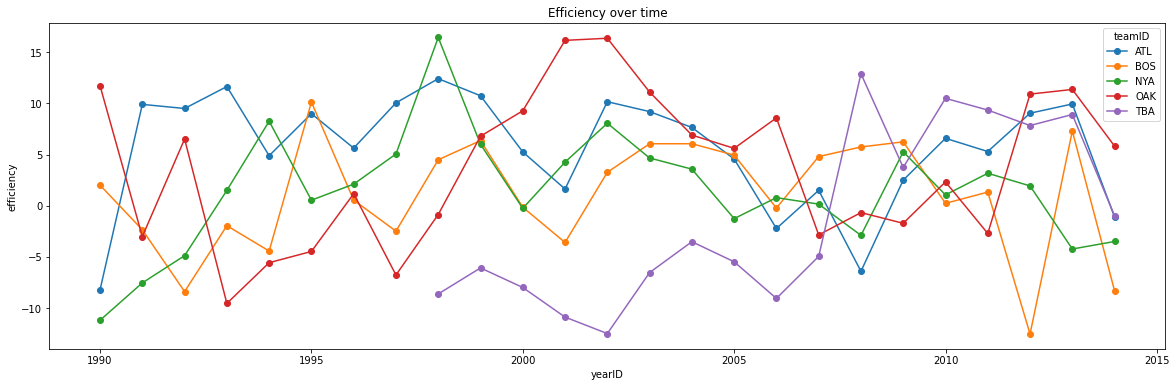

In [36]:
# plot line chart of efficiency over time for each of the above teams
ax = teams.pivot_table('efficiency', 'yearID', 'teamID').plot(
          kind='line', marker= 'o', figsize=[20,6], title = 'Efficiency over time', ylabel= "efficiency")

## Question 4 - Efficiency deficiency 
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period? <br /> <br />
Because the standardized z-score allows for comparisons over the whole time period, it is possible to see the data over time relative to the mean (i.e. how one team performs compared to the others in the same year). Not only is the graph easier to create and read with the standardized data, it also allows more meaningful conclusions to be drawn for the purpose of this investigation.  <br /> <br />
In the beginning of the Moneyball period, Oakland had a very good efficiency. It began to decline towards the end of the period and has not reached that peak again. 